This project aims to develop a predictive model to determine if it will rain on the following day, using local weather information.

On this purpose, 6 cities from different regions of Australia were selected: Adelaide, Alice Springs, Brisbane, Melbourne, Perth and Sydney.

Dependencies:

Python 3.7.4

Pandas 0.25.1

NumPy 1.16.5

Sklearn 0.22.1

MatplotLib 3.1.1

IPython: 7.8.0

In [1]:
# Import libraries

import pandas as pd
import numpy as np
# Produces a prediction model in the form of an ensemble of weak prediction models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from time import time
from sklearn.metrics import f1_score
# Standardising the data
from sklearn.preprocessing import scale
# Time Series cross-validator
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
# Displayd data
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

Read data from cvs file

In [2]:
data = pd.read_csv('rain_data_aus.csv')

Data prep

In [3]:
# Remove all rows with NaN in columns 'raintoday' and 'raintomorrow'
data['raintoday'].dropna(axis=0) 
data['raintomorrow'].dropna(axis=0)

# Replace 'No' and 'Yes' by 0 and 1, respectively
data = data.replace(to_replace=['No', 'Yes'], value=[0, 1])
# Sort dates
data['date'] = pd.to_datetime(data.date)
data = data.sort_values(by='date')

# Visualize 
print(data.shape)
display(data.head(3)) 
display(data.tail(3))

(142193, 23)


date  location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
44351 2007-11-01  Canberra      8.0     24.3       0.0          3.4       6.3   
44352 2007-11-02  Canberra     14.0     26.9       3.6          4.4       9.7   
44353 2007-11-03  Canberra     13.7     23.4       3.6          5.8       3.3   

       humidity9am  humidity3pm  pressure9am  ...  temp9am  temp3pm  \
44351         68.0         29.0       1019.7  ...     14.4     23.6   
44352         80.0         36.0       1012.4  ...     17.5     25.7   
44353         82.0         69.0       1009.5  ...     15.4     20.2   

       raintoday  amountOfRain  raintomorrow   temp  humidity  \
44351        0.0           3.6             1  31.16      36.8   
44352        1.0           3.6             1  34.28      45.2   
44353        1.0          39.8             1  30.08      84.8   

       precipitation3pm  precipitation9am  modelo_vigente  
44351                11          9.613089        0.538687  
44352                 9         17.115142        0.445920  
44353                11         17.391294        0.861744  

[3 rows x 23 columns]

date       location  mintemp  maxtemp  rainfall  evaporation  \
29496 2017-06-25       Richmond      2.7     20.0       0.2          NaN   
26545 2017-06-25        Penrith      3.1     20.0       0.0          NaN   
35838 2017-06-25  SydneyAirport      6.8     19.5       0.0          3.4   

       sunshine  humidity9am  humidity3pm  pressure9am  ...  temp9am  temp3pm  \
29496       NaN         88.0         35.0       1018.8  ...      9.6     19.4   
26545       NaN         95.0         45.0          NaN  ...      7.8     17.8   
35838       9.4         67.0         42.0       1018.4  ...     11.9     17.9   

       raintoday  amountOfRain  raintomorrow       temp  humidity  \
29496        0.0           0.0             0  26.000000      44.0   
26545        0.0           0.0             0  26.000000      56.0   
35838        0.0           0.0             0   2.742626      52.4   

       precipitation3pm  precipitation9am  modelo_vigente  
29496                13          5.257638        0.054258  
26545                10         15.136587        0.070515  
35838                 7         12.327163        0.026886  

[3 rows x 23 columns]

Select each city from a different region of Australia

In [4]:
city_1 = data.loc[data['location'] == "Adelaide"]
city_2 = data.loc[data['location'] == "AliceSprings"]
city_3 = data.loc[data['location'] == "Brisbane"]
city_4 = data.loc[data['location'] == "Melbourne"]
city_5 = data.loc[data['location'] == "Perth"]
city_6 = data.loc[data['location'] == "Sydney"]

city_1 = city_1.reset_index()
city_2 = city_2.reset_index()
city_3 = city_3.reset_index()
city_4 = city_4.reset_index()
city_5 = city_5.reset_index()
city_6 = city_6.reset_index()

print ("City 1 - Adelaide (South Australia) data shape: ",         city_1.shape)
print ("City 2 - Alice Springs (Northern Territory) data shape: ", city_2.shape)
print ("City 3 - Brisbane (Queensland) data shape: ",              city_3.shape)
print ("City 4 - Melbourne (Victoria) data shape: ",               city_4.shape)
print ("City 5 - Perth (Western Australia) data shape: ",          city_5.shape)
print ("City 6 - Sydney (New South Wales) data shape: ",           city_6.shape)

City 1 - Adelaide (South Australia) data shape:  (3090, 24)
City 2 - Alice Springs (Northern Territory) data shape:  (3031, 24)
City 3 - Brisbane (Queensland) data shape:  (3161, 24)
City 4 - Melbourne (Victoria) data shape:  (2435, 24)
City 5 - Perth (Western Australia) data shape:  (3193, 24)
City 6 - Sydney (New South Wales) data shape:  (3337, 24)


Visualize data from city 1

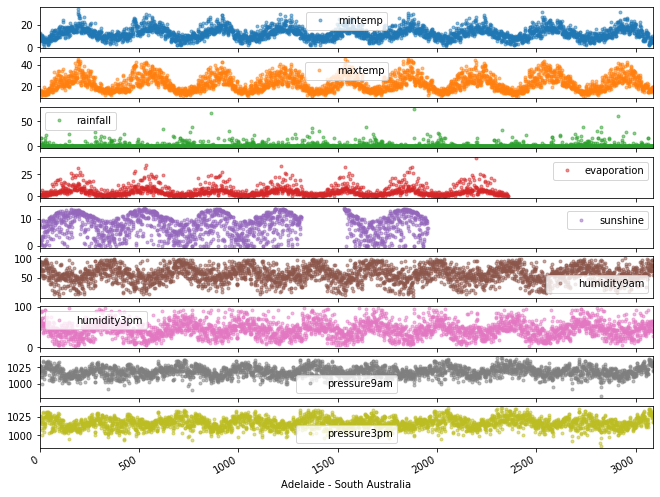

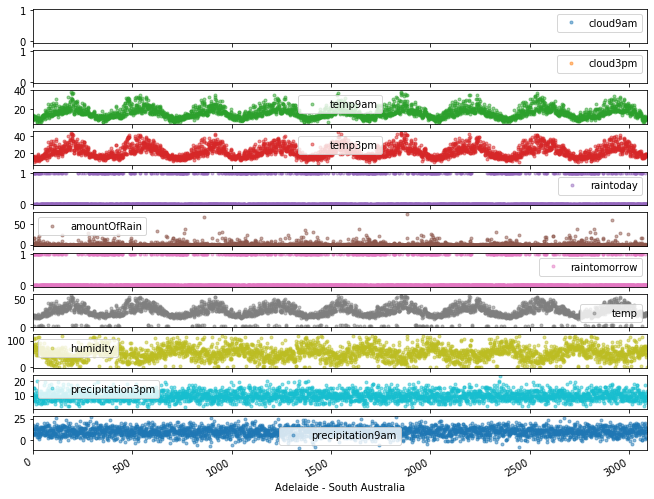

In [5]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_1[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Adelaide - South Australia')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_1[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Adelaide - South Australia')

City 1: data prep update

In [6]:
# Remove 'cloud9am' and 'cloud3pm' columns
city_1 = city_1.drop(['cloud9am', 'cloud3pm'],1)

# Interpolate NaN values according to ‘nearest’ method 
city_1 = city_1.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_1 = city_1.dropna(axis=0)

Dealing with imbalanced data

In [7]:
# Separate input features and target
X = city_1.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_1['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_1[city_1['raintomorrow'] == 0]
res_1 = city_1[city_1['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_1 = pd.concat([res_0, new_dataset])

print ("City 1 - Adelaide new data shape: ", city_1.shape)

(2402, 22) (688, 22)
City 1 - Adelaide new data shape:  (4804, 22)


Visualize data from city 2

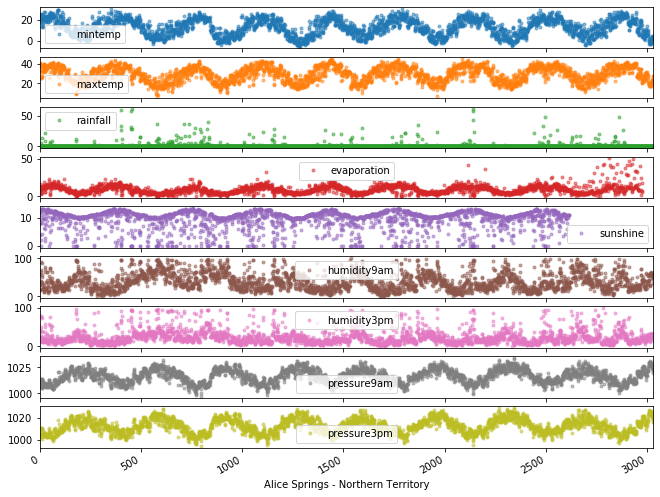

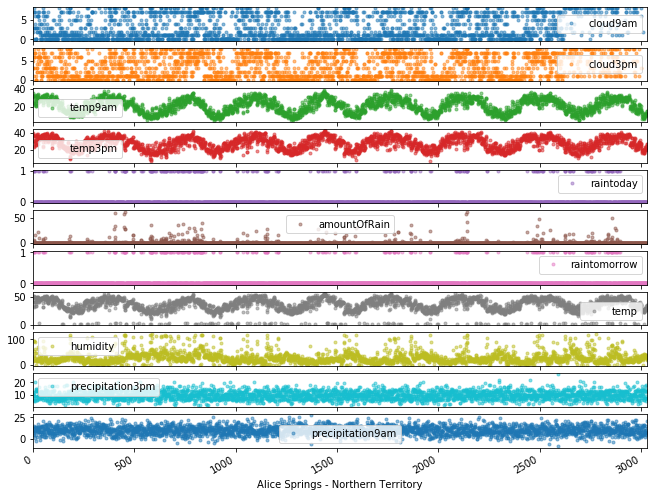

In [8]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Alice Springs - Northern Territory')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Alice Springs - Northern Territory')

City 2: data prep update

In [9]:
# Interpolate NaN values according to ‘nearest’ method 
city_2 = city_2.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_2 = city_2.dropna(axis=0)

Dealing with imbalanced data

In [10]:
# Separate input features and target
X = city_2.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_2['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_2[city_2['raintomorrow'] == 0]
res_1 = city_2[city_2['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_2 = pd.concat([res_0, new_dataset])

print ("City 2 - Alice Springs new data shape: ", city_2.shape)

(2787, 24) (244, 24)
City 2 - Alice Springs new data shape:  (5574, 24)


Visualize data from city 3

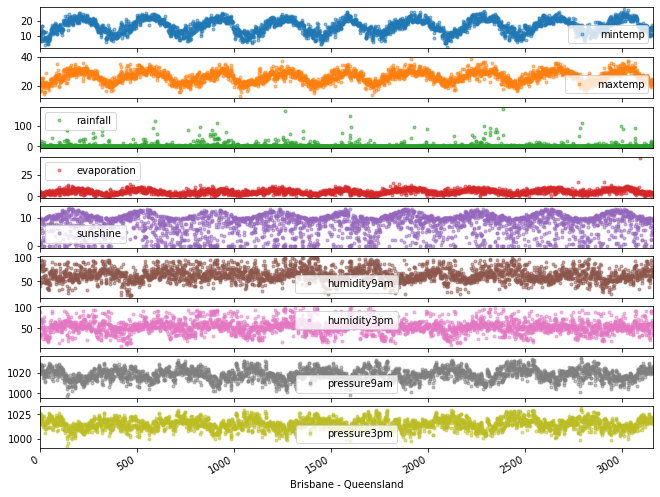

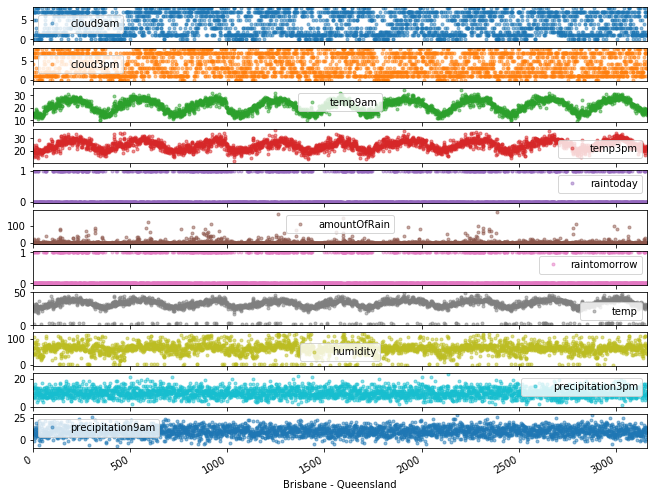

In [11]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_3[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Brisbane - Queensland')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_3[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Brisbane - Queensland')

City 3: data prep update

In [12]:
# Interpolate NaN values according to ‘nearest’ method 
city_3 = city_3.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_3 = city_3.dropna(axis=0)

Dealing with imbalanced data

In [13]:
# Separate input features and target
X = city_3.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_3['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_3[city_3['raintomorrow'] == 0]
res_1 = city_3[city_3['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_3 = pd.concat([res_0, new_dataset])

print ("City 3 - Brisbane new data shape: ", city_3.shape)

(2452, 24) (709, 24)
City 3 - Brisbane new data shape:  (4904, 24)


Visualize data from city 4

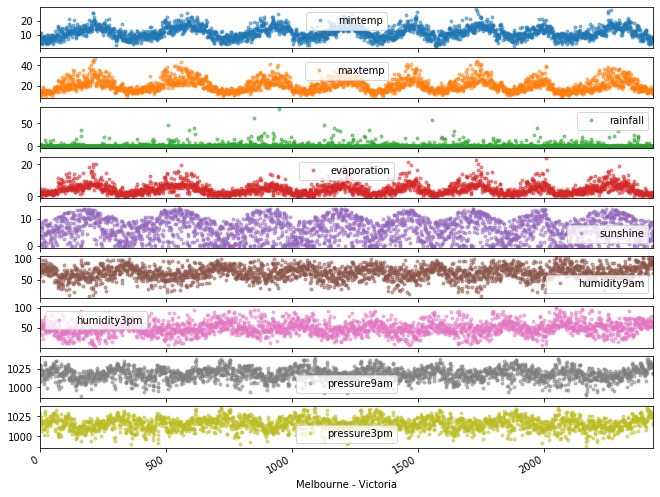

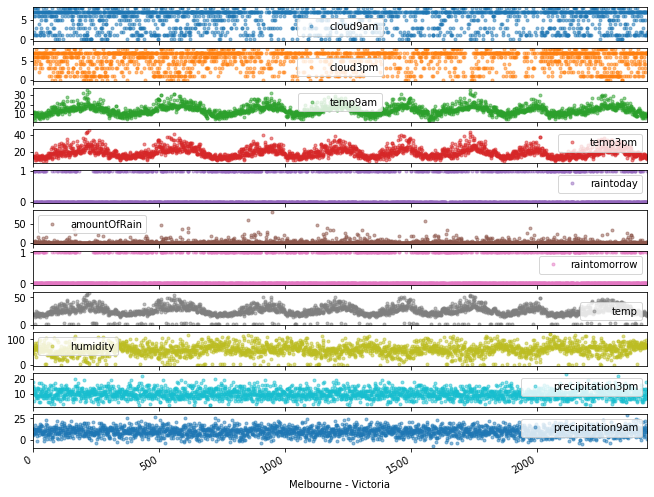

In [14]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_4[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Melbourne - Victoria')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_4[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Melbourne - Victoria')

City 4: data prep update

In [15]:
# Interpolate NaN values according to ‘nearest’ method 
city_4 = city_4.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_4 = city_4.dropna(axis=0)

Dealing with imbalanced data

In [16]:
# Separate input features and target
X = city_4.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_4['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_4[city_4['raintomorrow'] == 0]
res_1 = city_4[city_4['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_4 = pd.concat([res_0, new_dataset])

print ("City 4 - Melbourne new data shape: ", city_4.shape)

(1799, 24) (636, 24)
City 4 - Melbourne new data shape:  (3598, 24)


Visualize data from city 5

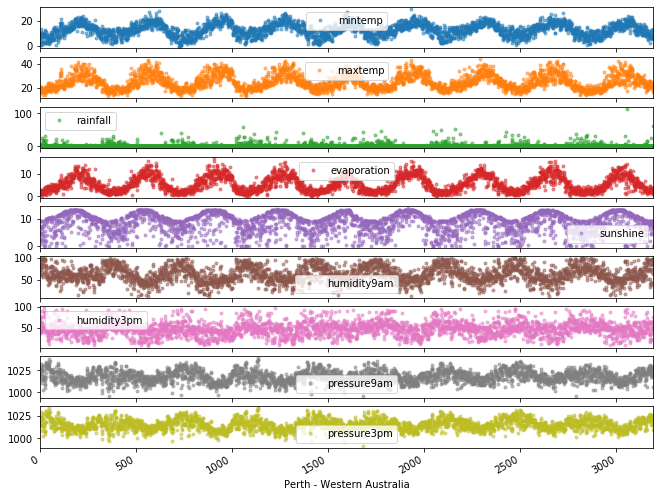

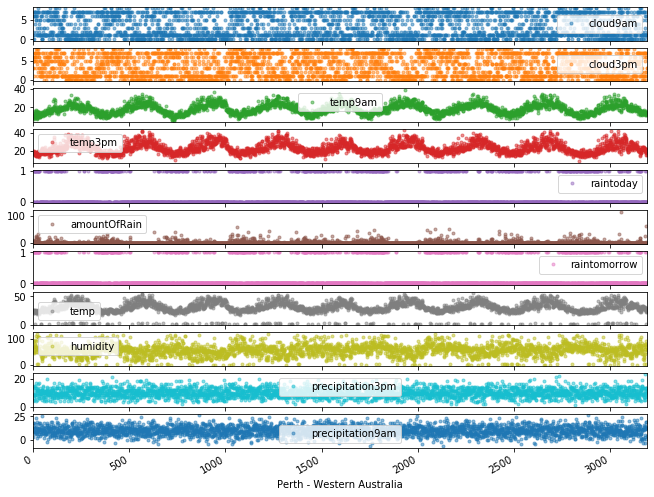

In [17]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_5[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Perth - Western Australia')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_5[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Perth - Western Australia')

City 5: data prep update

In [18]:
# Interpolate NaN values according to ‘nearest’ method 
city_5 = city_5.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_5 = city_5.dropna(axis=0)

Dealing with imbalanced data

In [19]:
# Separate input features and target
X = city_5.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_5['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_5[city_5['raintomorrow'] == 0]
res_1 = city_5[city_5['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_5 = pd.concat([res_0, new_dataset])

print ("City 5 - Perth new data shape: ", city_5.shape)

(2548, 24) (645, 24)
City 5 - Perth new data shape:  (5096, 24)


Visualize data from city 6

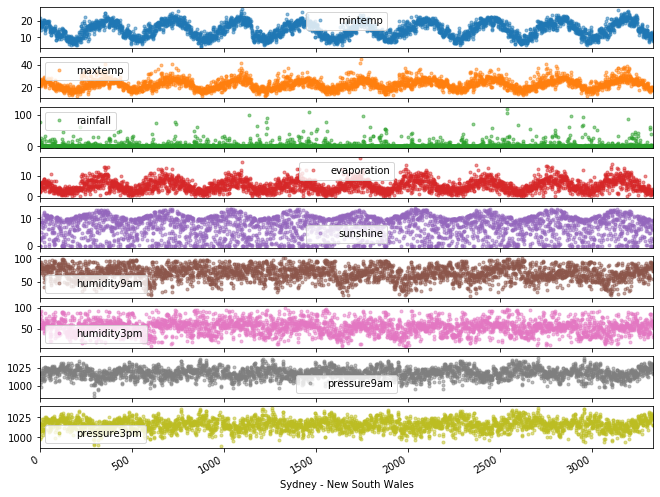

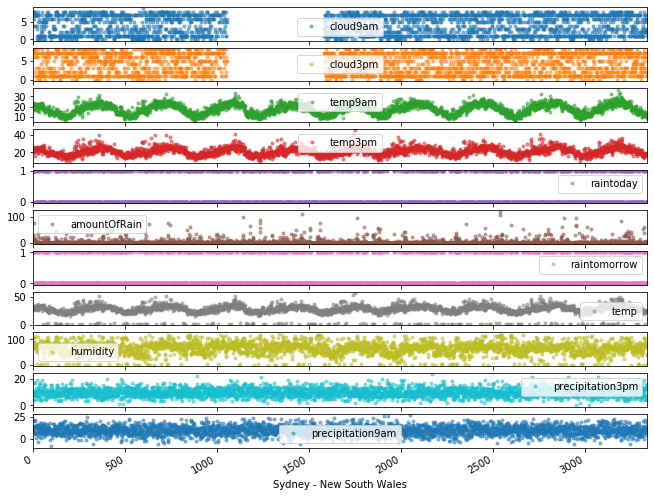

In [20]:
cols_plot = ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine','humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm']
axes = city_6[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Sydney - New South Wales')
    
cols_plot = ['cloud9am', 'cloud3pm', 'temp9am', 'temp3pm','raintoday', 'amountOfRain', 'raintomorrow', 'temp','humidity', 'precipitation3pm', 'precipitation9am']
axes = city_6[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_xlabel('Sydney - New South Wales')

City 6: data prep update

In [21]:
# Interpolate NaN values according to ‘nearest’ method 
city_6 = city_6.interpolate(method='nearest', fill_value='extrapolate')
# Remove rows with first value equals to NaN 
city_6 = city_6.dropna(axis=0)

Dealing with imbalanced data

In [22]:
# Separate input features and target
X = city_6.drop(['raintomorrow'] ,1) # Remove the output from the main data
y = city_6['raintomorrow'] # Out


# separate minority and majority classes
res_0 = city_6[city_6['raintomorrow'] == 0]
res_1 = city_6[city_6['raintomorrow'] == 1]

print(res_0.shape, res_1.shape)

# upsample minority
new_dataset = resample(res_1,
                          replace = True, # sample with replacement
                          n_samples = len(res_0), # match number in majority class
                          random_state = 27) # reproducible results

# combine majority and upsampled minority
city_6 = pd.concat([res_0, new_dataset])

print ("City 6 - Sydney new data shape: ", city_6.shape)

(2472, 24) (865, 24)
City 6 - Sydney new data shape:  (4944, 24)


City 1: verify correlation beteween Adelaide's data

In [23]:
# Remove non applicable data
X_11 = city_1.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_11.corr()
corr.style.background_gradient(cmap='coolwarm')

Identify the correlated data and consider the median (less noise sensitive) of these values

In [24]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_1.loc[:,'temp']
col_temp_2 = city_1.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_1.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3], axis=1)
X_11['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_1.loc[:,'humidity']
col_humidity_2 = city_1.loc[:,'humidity9am':'humidity3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2], axis=1)
X_11['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_1.loc[:,'rainfall']
col_rain_2 = city_1.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_11['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_12 = X_11.drop(['temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm','rainfall', 'raintoday'],1)
corr = X_12.corr()
corr.style.background_gradient(cmap='coolwarm')

Consider the columns that best discriminate the target

In [26]:
X_13 = city_1.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_13.corr()
corr.style.background_gradient(cmap='coolwarm')

Separate datasets

In [27]:
# The first training model (X_11) considers all data
X_11 = X_11.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training (X_12) considers the median of correlated data
X_12 = X_12.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_13 = X_13.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_1 = city_1['raintomorrow'] # Out

Standardize dataset float values 

In [28]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_11[col]  = scale(X_11[col])
    
cols = [['evaporation', 'sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_12[col]  = scale(X_12[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_13[col]  = scale(X_13[col])
    
# Visualize 
display(X_11.head(3)) 
display(X_11.tail(3))

# Visualize 
display(X_12.head(3)) 
display(X_12.tail(3))

# Visualize 
display(X_13.head(3)) 
display(X_13.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
0 -0.753314 -0.872610  0.460333    -0.552691 -1.315357     1.447784   
1  0.037007 -0.858142 -0.273077    -0.587541  0.221524     0.599351   
2 -1.280195 -0.959414 -0.412774    -0.517841 -1.463134     0.898798   

   humidity3pm  pressure9am  pressure3pm   temp9am   temp3pm  raintoday  \
0     0.816586     0.021413     0.318444 -0.516602 -0.790805        1.0   
1     0.087715     0.686441     0.982916 -0.480442 -0.702141        0.0   
2     0.282081     1.404671     1.511781 -1.275963 -0.938580        0.0   

   amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
0     -0.397881 -0.605032  0.826789          0.307146         -0.732623   
1     -0.513476 -0.592845  0.141702          0.307146         -0.490592   
2     -0.513476 -0.678157  0.324392         -0.982369          1.493816   

   temp_median  humidity_median  rain_median  
0         14.9             82.4          3.0  
1         15.5             64.4          0.4  
2         13.9             69.2          0.0

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
1408 -0.550668 -1.147491  4.965567    -0.378441  1.049075     1.397876   
773   0.199124 -0.308379  0.285712    -0.622391  0.310190     1.248152   
1662 -0.570932 -1.161959  1.822381    -0.587541 -1.551800     1.248152   

      humidity3pm  pressure9am  pressure3pm   temp9am   temp3pm  raintoday  \
1408    -0.301016     0.500233     0.793067 -0.986683 -1.027244        1.0   
773     -0.641155    -0.949528    -1.173228 -0.263481 -0.140598        1.0   
1662     0.622221    -0.217997    -0.007012 -1.131323 -0.997689        1.0   

      amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
1408     -0.340084 -0.836595 -0.223677          0.307146          2.365145   
773      -0.311185 -0.129720 -0.543384          0.629524         -0.483831   
1662     -0.340084 -0.848782  0.644099         -0.015233          0.056102   

      temp_median  humidity_median  rain_median  
1408         13.3             54.8         15.9  
773          19.3             46.4          2.5  
1662         13.5             77.6          6.9

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
0    -0.552691 -1.315357     0.021413     0.318444     -0.397881   
1    -0.587541  0.221524     0.686441     0.982916     -0.513476   
2    -0.517841 -1.463134     1.404671     1.511781     -0.513476   

   precipitation3pm  precipitation9am  temp_median  humidity_median  \
0          0.307146         -0.732623    -0.785746         1.178150   
1          0.307146         -0.490592    -0.696891         0.317573   
2         -0.982369          1.493816    -0.933837         0.547060   

   rain_median  
0     0.553120  
1    -0.311807  
2    -0.444873

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
1408    -0.378441  1.049075     0.500233     0.793067     -0.340084   
773     -0.622391  0.310190    -0.949528    -1.173228     -0.311185   
1662    -0.587541 -1.551800    -0.217997    -0.007012     -0.340084   

      precipitation3pm  precipitation9am  temp_median  humidity_median  \
1408          0.307146          2.365145    -1.022691        -0.141401   
773           0.629524         -0.483831    -0.134145        -0.543004   
1662         -0.015233          0.056102    -0.993073         0.948663   

      rain_median  
1408     4.844489  
773      0.386788  
1662     1.850511

amountOfRain  humidity
0     -0.397881  0.826789
1     -0.513476  0.141702
2     -0.513476  0.324392

amountOfRain  humidity
1408     -0.340084 -0.223677
773      -0.311185 -0.543384
1662     -0.340084  0.644099

Split our data in training and testing dataset 

In [29]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_11):
    X_11_train, X_11_test = X_11.iloc[train_index, :], X_11.iloc[test_index,:]
    X_12_train, X_12_test = X_12.iloc[train_index, :], X_12.iloc[test_index,:]
    X_13_train, X_13_test = X_13.iloc[train_index, :], X_13.iloc[test_index,:]
    y_1_train,  y_1_test  = y_1.iloc[train_index],     y_1.iloc[test_index]

City 2: verify correlation beteween Alice Springs' data

In [30]:
# Remove non applicable data
X_21 = city_2.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_21.corr()
corr.style.background_gradient(cmap='coolwarm')

Identify the correlated data and consider the median (less noise sensitive) of these values

In [31]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'evaporation', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_2.loc[:,'temp']
col_temp_2 = city_2.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_2.loc[:,'evaporation']
col_temp_4 = city_2.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3, col_temp_4], axis=1)
X_21['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_2.loc[:,'humidity']
col_humidity_2 = city_2.loc[:,'humidity9am':'humidity3pm']
col_humidity_3 = city_2.loc[:,'cloud9am': 'cloud3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2, col_humidity_3], axis=1)
X_21['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_2.loc[:,'rainfall']
col_rain_2 = city_2.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_21['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_22 = X_21.drop(['temp', 'mintemp', 'maxtemp','evaporation', 'temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm','rainfall', 'raintoday'],1)
corr = X_22.corr()
corr.style.background_gradient(cmap='coolwarm')

Consider the columns that best discriminate the target

In [32]:
X_23 = city_2.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_23.corr()
corr.style.background_gradient(cmap='coolwarm')

Separate datasets

In [33]:
# The first training model (X_21) considers all data
X_21 = X_21.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training (X_22) considers the median of correlated data
X_22 = X_22.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_23 = X_23.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_2 = city_2['raintomorrow'] # Out

Standardize dataset float values 

In [34]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm','cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_21[col]  = scale(X_21[col])
    
cols = [['sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_22[col]  = scale(X_22[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_23[col]  = scale(X_23[col])
    
# Visualize 
display(X_21.head(3)) 
display(X_21.tail(3))

# Visualize 
display(X_22.head(3)) 
display(X_22.tail(3))

# Visualize 
display(X_23.head(3)) 
display(X_23.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
1  0.712556  1.305831 -0.207540     0.055835  1.012931    -1.236070   
2  0.968524  1.536657 -0.339533     0.527117  1.103522    -1.274081   
3  1.211020  1.485362 -0.339533     1.324669  0.016435    -0.817945   

   humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  raintoday  \
1    -0.909025    -0.806754    -0.986363 -0.800538  ...  1.426277        1.0   
2    -0.981006    -1.263147    -1.168853 -1.451383  ...  1.712891        0.0   
3    -0.513128    -0.898032    -0.636590 -0.475115  ...  1.204803        0.0   

   amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
1     -0.540816  1.185220 -0.850296         -1.241783         -0.099597   
2     -0.540816  1.366741 -0.921496          0.662311         -1.259489   
3     -0.521283  1.326403 -0.458695         -0.289736          0.483842   

   temp_median  humidity_median  rain_median  
1        35.35             13.0          1.1  
2        37.70             11.0          0.0  
3        34.40             24.0          0.0  

[3 rows x 22 columns]

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
2853  1.547820  0.754413 -0.317534     0.490864  0.741160     0.284382   
54    1.372684  1.408420 -0.317534     0.853388 -0.481813    -0.551866   
923  -1.133108 -1.682084 -0.339533    -0.886727 -1.455661    -0.019708   

      humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  \
2853    -0.405156    -0.639409    -0.712628  1.151999  ...  0.879105   
54       0.134703    -1.019737    -0.849495 -0.149692  ...  0.709743   
923      0.386638     1.566492     1.264349  0.826576  ... -1.700419   

      raintoday  amountOfRain      temp  humidity  precipitation3pm  \
2853        0.0     -0.404083  0.751585 -0.351895         -0.607085   
54          0.0     -0.404083  1.265896  0.182107         -0.289736   
923         0.0     -0.189216 -1.164473  0.431307         -0.607085   

      precipitation9am  temp_median  humidity_median  rain_median  
2853         -0.614654        30.80             27.0          0.1  
54           -1.723642        32.95             36.0          0.1  
923          -0.769030        12.55             49.0          0.0  

[3 rows x 22 columns]

sunshine  pressure9am  pressure3pm  amountOfRain  precipitation3pm  \
1  1.012931    -0.806754    -0.986363     -0.540816         -1.241783   
2  1.103522    -1.263147    -1.168853     -0.540816          0.662311   
3  0.016435    -0.898032    -0.636590     -0.521283         -0.289736   

   precipitation9am  temp_median  humidity_median  rain_median  
1         -0.099597     1.486494        -0.857860    -0.120201  
2         -1.259489     1.806040        -0.934452    -0.355431  
3          0.483842     1.357315        -0.436606    -0.355431

sunshine  pressure9am  pressure3pm  amountOfRain  precipitation3pm  \
2853  0.741160    -0.639409    -0.712628     -0.404083         -0.607085   
54   -0.481813    -1.019737    -0.849495     -0.404083         -0.289736   
923  -1.455661     1.566492     1.264349     -0.189216         -0.607085   

      precipitation9am  temp_median  humidity_median  rain_median  
2853         -0.614654     0.867798        -0.321719    -0.334047  
54           -1.723642     1.160148         0.022944    -0.334047  
923          -0.769030    -1.613786         0.520790    -0.355431

amountOfRain  humidity
1     -0.540816 -0.850296
2     -0.540816 -0.921496
3     -0.521283 -0.458695

amountOfRain  humidity
2853     -0.404083 -0.351895
54       -0.404083  0.182107
923      -0.189216  0.431307

Split our data in training and testing dataset

In [35]:
# Split our data in training and testing data set 

# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_21):
    X_21_train, X_21_test = X_21.iloc[train_index, :], X_21.iloc[test_index,:]
    X_22_train, X_22_test = X_22.iloc[train_index, :], X_22.iloc[test_index,:]
    X_23_train, X_23_test = X_23.iloc[train_index, :], X_23.iloc[test_index,:]
    y_2_train,  y_2_test  = y_2.iloc[train_index],     y_2.iloc[test_index]

City 3: verify correlation beteween Brisbane's data

In [36]:
# Remove non applicable data
X_31 = city_3.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_31.corr()
corr.style.background_gradient(cmap='coolwarm')

Identify the correlated data and consider the median (less noise sensitive) of these values

In [37]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_3.loc[:,'temp']
col_temp_2 = city_3.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_3.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3], axis=1)
X_31['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_3.loc[:,'humidity']
col_humidity_2 = city_3.loc[:,'humidity9am':'humidity3pm']
col_humidity_3 = city_3.loc[:,'cloud9am': 'cloud3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2, col_humidity_3], axis=1)
X_31['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_3.loc[:,'rainfall']
col_rain_2 = city_3.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_31['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_32 = X_31.drop(['temp', 'mintemp', 'maxtemp','temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm','rainfall', 'raintoday'],1)
corr = X_32.corr()
corr.style.background_gradient(cmap='coolwarm')

Consider the columns that best discriminate the target

In [38]:
X_33 = city_3.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_33.corr()
corr.style.background_gradient(cmap='coolwarm')

Separate datasets

In [39]:
# The first training model considers all data
X_31 = X_31.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training considers the median of correlated data
X_32 = X_32.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_33 = X_33.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_3 = city_3['raintomorrow'] # Out

Standardize dataset float values 

In [40]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm','cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_31[col]  = scale(X_31[col])
    
cols = [['evaporation','sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_32[col]  = scale(X_32[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_33[col]  = scale(X_33[col])
    
# Visualize 
display(X_31.head(3)) 
display(X_31.tail(3))

# Visualize 
display(X_32.head(3)) 
display(X_32.tail(3))

# Visualize 
display(X_33.head(3)) 
display(X_33.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
0 -1.555109 -0.314217 -0.343855    -1.516826  0.643883     0.991770   
1 -2.044590 -0.895563 -0.343855    -1.286729  0.717996    -1.904805   
2 -1.688604 -1.021943 -0.343855     0.170547  0.619179    -0.891004   

   humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  raintoday  \
0    -1.366051     0.313473     0.005750 -1.708999  ...  0.020488        0.0   
1    -1.793555     0.174210     0.040412 -1.708999  ... -0.559050        0.0   
2    -0.449970     0.626814     0.750982 -1.339453  ... -0.848819        0.0   

   amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
0     -0.418655 -0.001001 -1.049525         -0.654134         -0.505753   
1     -0.418655 -0.346895 -1.411622          0.963716          0.154946   
2     -0.368503 -0.422089 -0.273604          1.287286          0.301067   

   temp_median  humidity_median  rain_median  
0         24.6             37.0          0.0  
1         22.4             30.0          0.0  
2         21.3             52.0          0.0  

[3 rows x 22 columns]

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
1670 -0.665143 -0.516424 -0.343855    -0.136248  0.149798     0.267626   
1608  0.469564  0.418784 -0.208336     0.400643 -0.097245    -0.239275   
2562  0.069079 -1.047219  0.649953     0.860836 -1.381869     0.484869   

      humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  \
1670    -0.083538     1.914995     1.860164  0.138730  ... -0.743449   
1608     0.099678     0.209026     0.265715  0.877822  ...  0.468312   
2562     1.382191     0.800893     0.889630  0.877822  ... -1.138588   

      raintoday  amountOfRain      temp  humidity  precipitation3pm  \
1670        0.0     -0.343428 -0.121312  0.036764          1.934426   
1608        1.0     -0.105209  0.435126  0.191948         -0.977704   
2562        1.0     -0.105209 -0.437128  1.278238         -0.977704   

      precipitation9am  temp_median  humidity_median  rain_median  
1670         -1.939640         21.7             58.0          0.0  
1608         -0.900855         26.3             61.0          1.4  
2562         -0.506646         21.0             74.0          7.1  

[3 rows x 22 columns]

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
0    -1.516826  0.643883     0.313473     0.005750     -0.418655   
1    -1.286729  0.717996     0.174210     0.040412     -0.418655   
2     0.170547  0.619179     0.626814     0.750982     -0.368503   

   precipitation3pm  precipitation9am  temp_median  humidity_median  \
0         -0.654134         -0.505753    -0.004322        -1.068601   
1          0.963716          0.154946    -0.582092        -1.467256   
2          1.287286          0.301067    -0.870978        -0.214341   

   rain_median  
0    -0.360469  
1    -0.360469  
2    -0.360469

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
1670    -0.136248  0.149798     1.914995     1.860164     -0.343428   
1608     0.400643 -0.097245     0.209026     0.265715     -0.105209   
2562     0.860836 -1.381869     0.800893     0.889630     -0.105209   

      precipitation3pm  precipitation9am  temp_median  humidity_median  \
1670          1.934426         -1.939640    -0.765928         0.127363   
1608         -0.977704         -0.900855     0.442137         0.298215   
2562         -0.977704         -0.506646    -0.949764         1.038574   

      rain_median  
1670    -0.360469  
1608    -0.153399  
2562     0.689670

amountOfRain  humidity
0     -0.418655 -1.049525
1     -0.418655 -1.411622
2     -0.368503 -0.273604

amountOfRain  humidity
1670     -0.343428  0.036764
1608     -0.105209  0.191948
2562     -0.105209  1.278238

Split our data in training and testing dataset

In [41]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_31):
    X_31_train, X_31_test = X_31.iloc[train_index, :], X_31.iloc[test_index,:]
    X_32_train, X_32_test = X_32.iloc[train_index, :], X_32.iloc[test_index,:]
    X_33_train, X_33_test = X_33.iloc[train_index, :], X_33.iloc[test_index,:]
    y_3_train,  y_3_test  = y_3.iloc[train_index],     y_3.iloc[test_index]

City 4: verify correlation beteween Melbourne's data

In [42]:
# Remove non applicable data
X_41 = city_4.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_41.corr()
corr.style.background_gradient(cmap='coolwarm')

Identify the correlated data and consider the median (less noise sensitive) of these values

In [43]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'evaporation', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_4.loc[:,'temp']
col_temp_2 = city_4.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_4.loc[:,'evaporation']
col_temp_4 = city_4.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3, col_temp_4], axis=1)
X_41['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_4.loc[:,'humidity']
col_humidity_2 = city_4.loc[:,'humidity9am':'humidity3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2], axis=1)
X_41['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_4.loc[:,'rainfall']
col_rain_2 = city_4.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_41['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_42 = X_41.drop(['temp', 'mintemp', 'maxtemp','evaporation', 'temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm', 'rainfall', 'raintoday'],1)
corr = X_42.corr()
corr.style.background_gradient(cmap='coolwarm')

Consider the columns that best discriminate the target

In [44]:
X_43 = city_4.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_43.corr()
corr.style.background_gradient(cmap='coolwarm')

Separate datasets

In [45]:
# The first training model considers all data
X_41 = X_41.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training considers the median of correlated data
X_42 = X_42.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_43 = X_43.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_4 = city_4['raintomorrow'] # Out

Standardize dataset float values 

In [46]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm','cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_41[col]  = scale(X_41[col])
    
cols = [['sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'cloud9am', 'cloud3pm', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_42[col]  = scale(X_42[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_43[col]  = scale(X_43[col])
    
# Visualize 
display(X_41.head(3)) 
display(X_41.tail(3))

# Visualize 
display(X_42.head(3)) 
display(X_42.tail(3))

# Visualize 
display(X_43.head(3)) 
display(X_43.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
0 -0.561239 -0.832100 -0.056180    -0.524076  0.328917    -0.540359   
2 -0.819734 -1.048915 -0.149645    -0.763445 -1.254559     0.249329   
3 -0.655237 -0.982203 -0.274266    -0.823287 -0.386201     1.236438   

   humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  raintoday  \
0    -0.907421    -1.164862    -0.525409 -1.865917  ... -0.733010        1.0   
2     0.248255     1.058546     1.251256  0.623356  ... -0.855919        1.0   
3    -0.271799     1.725568     1.847707  0.623356  ... -0.996385        0.0   

   amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
0     -0.440762 -0.563316 -0.731505          1.524259          0.850495   
2     -0.440762 -0.742396  0.306495         -0.018697          0.526930   
3     -0.530011 -0.687294 -0.160605          1.215668         -0.264083   

   temp_median  humidity_median  rain_median  
0        12.80             47.6          1.5  
2        12.25             71.6          1.2  
3        11.65             60.8          0.3  

[3 rows x 22 columns]

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
1406 -1.195726 -0.782066 -0.367732    -0.763445 -0.871460     0.512558   
1117 -0.561239  1.319371 -0.336577    -0.344550  1.018496    -1.988120   
1162  0.284744  0.485467 -0.367732    -0.643760  1.580375    -0.342937   

      humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  \
1406     0.479390     0.515046     0.654804 -1.451038  ... -0.926152   
1117    -1.889746    -0.954874    -1.769074 -1.036159  ...  1.549576   
1162    -1.485259    -0.337260    -0.195457 -1.036159  ...  0.566308   

      raintoday  amountOfRain      temp  humidity  precipitation3pm  \
1406        0.0      0.213729 -0.521989  0.514095         -1.561653   
1117        0.0      0.035232  1.213711 -1.613806          1.215668   
1162        0.0      3.188691  0.524941 -1.250506         -0.635880   

      precipitation9am  temp_median  humidity_median  rain_median  
1406          1.401738        11.55             76.0          0.0  
1117         -0.533856        24.00             27.2          0.1  
1162          0.796876        18.85             35.6          0.0  

[3 rows x 22 columns]

sunshine  pressure9am  pressure3pm  cloud9am  cloud3pm  amountOfRain  \
0  0.328917    -1.164862    -0.525409 -1.865917  0.606111     -0.440762   
2 -1.254559     1.058546     1.251256  0.623356  0.606111     -0.440762   
3 -0.386201     1.725568     1.847707  0.623356  0.144276     -0.530011   

   precipitation3pm  precipitation9am  temp_median  humidity_median  \
0          1.524259          0.850495    -0.746809        -0.839853   
2         -0.018697          0.526930    -0.855231         0.577548   
3          1.215668         -0.264083    -0.973509        -0.060283   

   rain_median  
0     0.050501  
2    -0.039347  
3    -0.308893

sunshine  pressure9am  pressure3pm  cloud9am  cloud3pm  amountOfRain  \
1406 -0.871460     0.515046     0.654804 -1.451038 -2.164904      0.213729   
1117  1.018496    -0.954874    -1.769074 -1.036159  0.606111      0.035232   
1162  1.580375    -0.337260    -0.195457 -1.036159 -0.317560      3.188691   

      precipitation3pm  precipitation9am  temp_median  humidity_median  \
1406         -1.561653          1.401738    -0.993223         0.837404   
1117          1.215668         -0.533856     1.461055        -2.044644   
1162         -0.635880          0.796876     0.445831        -1.548554   

      rain_median  
1406    -0.398741  
1117    -0.368792  
1162    -0.398741

amountOfRain  humidity
0     -0.440762 -0.731505
2     -0.440762  0.306495
3     -0.530011 -0.160605

amountOfRain  humidity
1406      0.213729  0.514095
1117      0.035232 -1.613806
1162      3.188691 -1.250506

Split our data in training and testing dataset

In [47]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_41):
    X_41_train, X_41_test = X_41.iloc[train_index, :], X_41.iloc[test_index,:]
    X_42_train, X_42_test = X_42.iloc[train_index, :], X_42.iloc[test_index,:]
    X_43_train, X_43_test = X_43.iloc[train_index, :], X_43.iloc[test_index,:]
    y_4_train,  y_4_test  = y_4.iloc[train_index],     y_4.iloc[test_index]

City 5: verify correlation beteween Perth's data

In [48]:
# Remove non applicable data
X_51 = city_5.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_51.corr()
corr.style.background_gradient(cmap='coolwarm') 

Identify the correlated data and consider the median (less noise sensitive) of these values

In [49]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'evaporation', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_5.loc[:,'temp']
col_temp_2 = city_5.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_5.loc[:,'evaporation']
col_temp_4 = city_5.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3, col_temp_4], axis=1)
X_51['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_5.loc[:,'humidity']
col_humidity_2 = city_5.loc[:,'humidity9am':'humidity3pm']
col_humidity_3 = city_5.loc[:,'cloud9am': 'cloud3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2, col_humidity_3], axis=1)
X_51['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_5.loc[:,'rainfall']
col_rain_2 = city_5.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_51['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_52 = X_51.drop(['temp', 'mintemp', 'maxtemp','evaporation', 'temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm','rainfall', 'raintoday'],1)
corr = X_52.corr()
corr.style.background_gradient(cmap='coolwarm') 

Consider the columns that best discriminate the target

In [50]:
X_53 = city_5.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_53.corr()
corr.style.background_gradient(cmap='coolwarm') 

Separate datasets

In [51]:
# The first training model considers all data
X_51 = X_51.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training considers the median of correlated data
X_52 = X_52.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_53 = X_53.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_5 = city_5['raintomorrow'] # Out

Standardize dataset float values 

In [53]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm','cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_51[col]  = scale(X_51[col])
    
cols = [['sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_52[col]  = scale(X_52[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_53[col]  = scale(X_53[col])
    
# Visualize 
display(X_51.head(3)) 
display(X_51.tail(3))

# Visualize 
display(X_52.head(3)) 
display(X_52.tail(3))

# Visualize 
display(X_53.head(3)) 
display(X_53.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
0 -2.117765 -0.822491 -0.417032    -1.262203  0.450648     1.664963   
1 -1.334556 -0.496539 -0.417032    -0.954322 -0.108448     0.719400   
5 -2.541121 -1.319996  0.467956    -0.769594  0.503895     1.053128   

   humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  raintoday  \
0    -0.012181     1.744251     1.705539 -0.768892  ... -0.664940        0.0   
1    -0.769210     1.199772     0.792614 -1.478210  ... -0.383980        0.0   
5    -0.661063     2.428740     2.552070 -1.478210  ... -1.121501        1.0   

   amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
0     -0.550293 -0.472634  0.058886          1.278617          0.535707   
1     -0.504119 -0.223967 -0.635194         -0.290707          1.722011   
5     -0.550293 -0.852179 -0.536039         -0.604571         -0.379752   

   temp_median  humidity_median  rain_median  
0         13.3             53.0          0.0  
1         15.4             39.0          0.0  
5         11.2             41.0          3.9  

[3 rows x 22 columns]

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
15   -0.530180 -1.114132  2.706455    -0.954322 -0.188319     0.496914   
400  -1.059375 -0.582316 -0.417032    -1.015898 -0.481179     0.441293   
2063  0.401204 -0.410762  4.606576    -0.954322 -0.348061     1.164371   

      humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  \
15       0.041892    -0.402553     0.095471  0.649744  ... -1.051261   
400      0.258186    -0.153648    -0.369290 -0.059574  ... -0.489340   
2063     0.312259    -1.180381    -1.016637 -1.123551  ... -0.383980   

      raintoday  amountOfRain      temp  humidity  precipitation3pm  \
15          1.0     -0.250161 -0.695126  0.108463         -1.860030   
400         0.0      0.073058 -0.289405  0.306772          1.592481   
2063        1.0      0.788757 -0.158528 -2.567994         -0.604571   

      precipitation9am  temp_median  humidity_median  rain_median  
15           -0.388906        14.55             54.0         12.5  
400          -0.881811        16.35             58.0          0.0  
2063         -0.595746        18.20              3.0         19.8  

[3 rows x 22 columns]

sunshine  pressure9am  pressure3pm  amountOfRain  precipitation3pm  \
0  0.450648     1.744251     1.705539     -0.550293          1.278617   
1 -0.108448     1.199772     0.792614     -0.504119         -0.290707   
5  0.503895     2.428740     2.552070     -0.550293         -0.604571   

   precipitation9am  temp_median  humidity_median  rain_median  
0          0.535707    -1.219709         0.165319    -0.441282  
1          1.722011    -0.813143        -0.600288    -0.441282  
5         -0.379752    -1.626275        -0.490916     0.537079

sunshine  pressure9am  pressure3pm  amountOfRain  precipitation3pm  \
15   -0.188319    -0.402553     0.095471     -0.250161         -1.860030   
400  -0.481179    -0.153648    -0.369290      0.073058          1.592481   
2063 -0.348061    -1.180381    -1.016637      0.788757         -0.604571   

      precipitation9am  temp_median  humidity_median  rain_median  
15           -0.388906    -0.977705         0.220005     2.694490  
400          -0.881811    -0.629220         0.438750    -0.441282  
2063         -0.595746    -0.271055        -2.568992     4.525781

amountOfRain  humidity
0     -0.550293  0.058886
1     -0.504119 -0.635194
5     -0.550293 -0.536039

amountOfRain  humidity
15       -0.250161  0.108463
400       0.073058  0.306772
2063      0.788757 -2.567994

Split our data in training and testing dataset

In [54]:
# Split our data in training and testing data set 

# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_51):
    X_51_train, X_51_test = X_51.iloc[train_index, :], X_51.iloc[test_index,:]
    X_52_train, X_52_test = X_52.iloc[train_index, :], X_52.iloc[test_index,:]
    X_53_train, X_53_test = X_53.iloc[train_index, :], X_53.iloc[test_index,:]
    y_5_train,  y_5_test  = y_5.iloc[train_index],     y_5.iloc[test_index]

City 6: verify correlation beteween Sydney's data

In [55]:
# Remove non applicable data
X_61 = city_6.drop(['index','date', 'location', 'modelo_vigente'],1)
corr = X_61.corr()
corr.style.background_gradient(cmap='coolwarm')

Identify the correlated data and consider the median (less noise sensitive) of these values

In [56]:
# Correlation 1: 'temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm'
# Correlation 2: 'humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm'
# Correlation 3: 'rainfall', 'raintoday'

col_temp_1 = city_6.loc[:,'temp']
col_temp_2 = city_6.loc[:,'mintemp':'maxtemp']
col_temp_3 = city_6.loc[:,'temp9am':'temp3pm']
col_temp = pd.concat([col_temp_1, col_temp_2, col_temp_3], axis=1)
X_61['temp_median'] = col_temp.median(axis=1)

col_humidity_1 = city_6.loc[:,'humidity']
col_humidity_2 = city_6.loc[:,'humidity9am':'humidity3pm']
col_humidity_3 = city_6.loc[:,'cloud9am': 'cloud3pm']
col_humidity = pd.concat([col_humidity_1, col_humidity_2, col_humidity_3], axis=1)
X_61['humidity_median'] = col_humidity.median(axis=1)

col_rain_1 = city_6.loc[:,'rainfall']
col_rain_2 = city_6.loc[:,'raintoday']
col_rain = pd.concat([col_rain_1, col_rain_2], axis=1)
X_61['rain_median'] = col_rain.median(axis=1)

# Remove correlated data and consider median values
X_62 = X_61.drop(['temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm','humidity', 'humidity9am', 'humidity3pm', 'cloud9am', 'cloud3pm','rainfall', 'raintoday'],1)
corr = X_62.corr()
corr.style.background_gradient(cmap='coolwarm')

Consider the columns that best discriminate the target

In [57]:
X_63 = city_6.drop(['index','date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'temp', 'precipitation3pm', 'precipitation9am', 'modelo_vigente'] ,1)
corr = X_63.corr()
corr.style.background_gradient(cmap='coolwarm')

Separate datasets

In [58]:
# The first training model (X_21) considers all data
X_61 = X_61.drop(['raintomorrow'] ,1)  # Remove the output from the main data

# The second model for training (X_22) considers the median of correlated data
X_62 = X_62.drop(['raintomorrow'] ,1)  # Remove the output from the main data

#The third training model considers the data correlated with the output
X_63 = X_63.drop(['raintomorrow'] ,1) # Remove the output from the main data

y_6 = city_6['raintomorrow'] # Out

Standardize dataset float values 

In [59]:
cols = [['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm','cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]  
for col in cols:
    X_61[col]  = scale(X_61[col])
    
cols = [['evaporation','sunshine', 'pressure9am', 'pressure3pm', 'amountOfRain', 'precipitation3pm', 'precipitation9am', 'temp_median', 'humidity_median', 'rain_median']]  
for col in cols:
    X_62[col]  = scale(X_62[col])
    
cols = [['humidity','amountOfRain']]  
for col in cols:
    X_63[col]  = scale(X_63[col])
    
# Visualize 
display(X_61.head(3)) 
display(X_61.tail(3))

# Visualize 
display(X_62.head(3)) 
display(X_62.tail(3))

# Visualize 
display(X_63.head(3)) 
display(X_63.tail(3))

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
9  -0.095340  0.351221  0.326880    -0.252190  0.992730     0.612853   
10  0.304232  0.285973 -0.392416     0.472605  0.469611     0.480176   
13  0.415224  0.372970 -0.147202    -0.687067  0.643984     0.679192   

    humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  raintoday  \
9     -0.341612    -0.597581    -0.377262 -0.357202  ...  0.512526        1.0   
10    -0.341612    -0.092505    -0.112230  0.828567  ...  0.603686        0.0   
13    -0.457721    -0.148625     0.055159  0.828567  ...  0.512526        1.0   

    amountOfRain      temp  humidity  precipitation3pm  precipitation9am  \
9      -0.500234  0.411562 -0.198800          0.339248          0.778665   
10     -0.500234  0.366079 -0.198800         -0.616808         -0.858125   
13     -0.500234  0.426722 -0.299166         -1.891550         -0.593623   

    temp_median  humidity_median  rain_median  
9          23.3             53.0          4.9  
10         23.7             53.0          0.0  
13         23.3             51.0          2.0  

[3 rows x 22 columns]

mintemp   maxtemp  rainfall  evaporation  sunshine  humidity9am  \
3235  1.525146  0.503465 -0.179897     0.907482 -1.274122     0.878208   
1728  1.058978  0.329471 -0.098159    -0.252190 -1.274122     0.612853   
1574 -1.427246 -1.932446  0.326880    -1.121944 -1.523227     0.878208   

      humidity3pm  pressure9am  pressure3pm  cloud9am  ...   temp3pm  \
3235     1.516139    -0.709820    -0.991020  1.223823  ...  0.786006   
1728     0.877537    -0.583551    -0.195924  0.828567  ...  0.307416   
1574     1.632249     1.745409     1.868535  0.433311  ... -1.857634   

      raintoday  amountOfRain      temp  humidity  precipitation3pm  \
3235        1.0      1.082992  0.517687  1.407057         -1.572864   
1728        1.0      0.307211  0.396401  0.855043          0.339248   
1574        1.0      0.243882 -1.180318  1.507423          0.976618   

      precipitation9am  temp_median  humidity_median  rain_median  
3235         -1.970134         24.5             84.0          1.8  
1728         -1.505143         22.4             74.0          2.3  
1574         -0.328073         12.9             84.0          4.9  

[3 rows x 22 columns]

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
9     -0.252190  0.992730    -0.597581    -0.377262     -0.500234   
10     0.472605  0.469611    -0.092505    -0.112230     -0.500234   
13    -0.687067  0.643984    -0.148625     0.055159     -0.500234   

    precipitation3pm  precipitation9am  temp_median  humidity_median  \
9           0.339248          0.778665     0.515990        -0.154363   
10         -0.616808         -0.858125     0.605205        -0.154363   
13         -1.891550         -0.593623     0.515990        -0.261420   

    rain_median  
9      0.373365  
10    -0.410783  
13    -0.090723

evaporation  sunshine  pressure9am  pressure3pm  amountOfRain  \
3235     0.907482 -1.274122    -0.709820    -0.991020      1.082992   
1728    -0.252190 -1.274122    -0.583551    -0.195924      0.307211   
1574    -1.121944 -1.523227     1.745409     1.868535      0.243882   

      precipitation3pm  precipitation9am  temp_median  humidity_median  \
3235         -1.572864         -1.970134     0.783635         1.505021   
1728          0.339248         -1.505143     0.315257         0.969736   
1574          0.976618         -0.328073    -1.803597         1.505021   

      rain_median  
3235    -0.122729  
1728    -0.042714  
1574     0.373365

amountOfRain  humidity
9      -0.500234 -0.198800
10     -0.500234 -0.198800
13     -0.500234 -0.299166

amountOfRain  humidity
3235      1.082992  1.407057
1728      0.307211  0.855043
1574      0.243882  1.507423

Split our data in training and testing dataset

In [60]:
# Assign the time series method to a variable
tss = TimeSeriesSplit(n_splits = 3) # N-1: we split our data into two sets

for train_index, test_index in tss.split(X_61):
    X_61_train, X_61_test = X_61.iloc[train_index, :], X_61.iloc[test_index,:]
    X_62_train, X_62_test = X_62.iloc[train_index, :], X_62.iloc[test_index,:]
    X_63_train, X_63_test = X_63.iloc[train_index, :], X_63.iloc[test_index,:]
    y_6_train,  y_6_test  = y_6.iloc[train_index],     y_6.iloc[test_index]

In [61]:
# Makes predictions using a fit classifier based on F1 score
def predict_labels(clf, features, target):
    
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred), sum(target == y_pred) / float(len(y_pred))

# Fits a classifier to the training data
def train_classifier(clf, X_train, y_train):
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    trained_time = end - start
    print ("Trained time = {:.4f} s".format(trained_time))
    
    return trained_time

# Train and predict using a classifer based on F1 score
def train_predict(clf, X_train, y_train, X_test, y_test):
        
    print(clf.__class__.__name__)
    
    # Train the classifier
    trained_time = train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    train_f1, train_acc = predict_labels(clf, X_train, y_train)
    
    print ("Training F1 score = {:.4f}".format(train_f1))
    print ("Training accuracy = {:.4f}".format(train_acc))
    
    test_f1, test_acc = predict_labels(clf, X_test, y_test)
    
    print ("Test F1 score = {:.4f}".format(test_f1))
    print ("Test accuracy = {:.4f}".format(test_acc))
    
    return trained_time, train_f1, train_acc, test_f1, test_acc 

Results 

In [62]:
clf_A = LogisticRegression(random_state = 42)
clf_C = SVC(random_state = 912, kernel='rbf')

print('------------')
print('Adelaide - South Australia')
print ('')

print('All data')
print ('')
A_X11_trained_time, A_X11_train_f1, A_X11_train_acc, A_X11_test_f1, A_X11_test_acc = train_predict(clf_A, X_11_train, y_1_train, X_11_test, y_1_test)
print ('')
C_X11_trained_time, C_X11_train_f1, C_X11_train_acc, C_X11_test_f1, C_X11_test_acc = train_predict(clf_C, X_11_train, y_1_train, X_11_test, y_1_test)
print ('')

print('Median of correlated data')
print ('')
A_X12_trained_time, A_X12_train_f1, A_X12_train_acc, A_X12_test_f1, A_X12_test_acc = train_predict(clf_A, X_12_train, y_1_train, X_12_test, y_1_test)
print ('')
C_X12_trained_time, C_X12_train_f1, C_X12_train_acc, C_X12_test_f1, C_X12_test_acc = train_predict(clf_C, X_12_train, y_1_train, X_12_test, y_1_test)
print ('')

print('Data correlated with the desired output')
print ('')
A_X13_trained_time, A_X13_train_f1, A_X13_train_acc, A_X13_test_f1, A_X13_test_acc = train_predict(clf_A, X_13_train, y_1_train, X_13_test, y_1_test)
print ('')
C_X13_trained_time, C_X13_train_f1, C_X13_train_acc, C_X13_test_f1, C_X13_test_acc = train_predict(clf_C, X_13_train, y_1_train, X_13_test, y_1_test)
print ('')

print('------------')
print('Alice Springs - Northern Territory')
print ('')

print('All data')
print ('')
A_X21_trained_time, A_X21_train_f1, A_X21_train_acc, A_X21_test_f1, A_X21_test_acc = train_predict(clf_A, X_21_train, y_2_train, X_21_test, y_2_test)
print ('')
C_X21_trained_time, C_X21_train_f1, C_X21_train_acc, C_X21_test_f1, C_X21_test_acc = train_predict(clf_C, X_21_train, y_2_train, X_21_test, y_2_test)
print ('')

print('Median of correlated data')
print ('')
A_X22_trained_time, A_X22_train_f1, A_X22_train_acc, A_X22_test_f1, A_X22_test_acc = train_predict(clf_A, X_22_train, y_2_train, X_22_test, y_2_test)
print ('')
C_X22_trained_time, C_X22_train_f1, C_X22_train_acc, C_X22_test_f1, C_X22_test_acc = train_predict(clf_C, X_22_train, y_2_train, X_22_test, y_2_test)
print ('')


print('Data correlated with the desired output')
print ('')
A_X23_trained_time, A_X23_train_f1, A_X23_train_acc, A_X23_test_f1, A_X23_test_acc = train_predict(clf_A, X_23_train, y_2_train, X_23_test, y_2_test)
print ('')
C_X23_trained_time, C_X23_train_f1, C_X23_train_acc, C_X23_test_f1, C_X23_test_acc = train_predict(clf_C, X_23_train, y_2_train, X_23_test, y_2_test)
print ('')

print('------------')
print('Brisbane - Queensland')
print ('')

print('All data')
print ('')
A_X31_trained_time, A_X31_train_f1, A_X31_train_acc, A_X31_test_f1, A_X31_test_acc = train_predict(clf_A, X_31_train, y_3_train, X_31_test, y_3_test)
print ('')
C_X31_trained_time, C_X31_train_f1, C_X31_train_acc, C_X31_test_f1, C_X31_test_acc = train_predict(clf_C, X_31_train, y_3_train, X_31_test, y_3_test)
print ('')

print('Median of correlated data')
print ('')
A_X32_trained_time, A_X32_train_f1, A_X32_train_acc, A_X32_test_f1, A_X32_test_acc = train_predict(clf_A, X_32_train, y_3_train, X_32_test, y_3_test)
print ('')
C_X32_trained_time, C_X32_train_f1, C_X32_train_acc, C_X32_test_f1, C_X32_test_acc = train_predict(clf_C, X_32_train, y_3_train, X_32_test, y_3_test)
print ('')

print('Data correlated with the desired output')
print ('')
A_X33_trained_time, A_X33_train_f1, A_X33_train_acc, A_X33_test_f1, A_X33_test_acc = train_predict(clf_A, X_33_train, y_3_train, X_33_test, y_3_test)
print ('')
C_X33_trained_time, C_X33_train_f1, C_X33_train_acc, C_X33_test_f1, C_X33_test_acc = train_predict(clf_C, X_33_train, y_3_train, X_33_test, y_3_test)
print ('')

print('------------')
print('Melbourne - Victoria')
print ('')

print('All data')
print ('')
A_X41_trained_time, A_X41_train_f1, A_X41_train_acc, A_X41_test_f1, A_X41_test_acc = train_predict(clf_A, X_41_train, y_4_train, X_41_test, y_4_test)
print ('')
C_X41_trained_time, C_X41_train_f1, C_X41_train_acc, C_X41_test_f1, C_X41_test_acc = train_predict(clf_C, X_41_train, y_4_train, X_41_test, y_4_test)
print ('')

print('Median of correlated data')
print ('')
A_X42_trained_time, A_X42_train_f1, A_X42_train_acc, A_X42_test_f1, A_X42_test_acc = train_predict(clf_A, X_42_train, y_4_train, X_42_test, y_4_test)
print ('')
C_X42_trained_time, C_X42_train_f1, C_X42_train_acc, C_X42_test_f1, C_X42_test_acc = train_predict(clf_C, X_42_train, y_4_train, X_42_test, y_4_test)
print ('')

print('Data correlated with the desired output')
print ('')
A_X43_trained_time, A_X43_train_f1, A_X43_train_acc, A_X43_test_f1, A_X43_test_acc = train_predict(clf_A, X_43_train, y_4_train, X_43_test, y_4_test)
print ('')
C_X43_trained_time, C_X43_train_f1, C_X43_train_acc, C_X43_test_f1, C_X43_test_acc = train_predict(clf_C, X_43_train, y_4_train, X_43_test, y_4_test)
print ('')

print('------------')
print('Perth - Western Australia')
print ('')

print('All data')
print ('')
A_X51_trained_time, A_X51_train_f1, A_X51_train_acc, A_X51_test_f1, A_X51_test_acc = train_predict(clf_A, X_51_train, y_5_train, X_51_test, y_5_test)
print ('')
C_X51_trained_time, C_X51_train_f1, C_X51_train_acc, C_X51_test_f1, C_X51_test_acc = train_predict(clf_C, X_51_train, y_5_train, X_51_test, y_5_test)
print ('')

print('Median of correlated data')
print ('')
A_X52_trained_time, A_X52_train_f1, A_X52_train_acc, A_X52_test_f1, A_X52_test_acc = train_predict(clf_A, X_52_train, y_5_train, X_52_test, y_5_test)
print ('')
C_X52_trained_time, C_X52_train_f1, C_X52_train_acc, C_X52_test_f1, C_X52_test_acc = train_predict(clf_C, X_52_train, y_5_train, X_52_test, y_5_test)
print ('')

print('Data correlated with the desired output')
print ('')
A_X53_trained_time, A_X53_train_f1, A_X53_train_acc, A_X53_test_f1, A_X53_test_acc = train_predict(clf_A, X_53_train, y_5_train, X_53_test, y_5_test)
print ('')
C_X53_trained_time, C_X53_train_f1, C_X53_train_acc, C_X53_test_f1, C_X53_test_acc = train_predict(clf_C, X_53_train, y_5_train, X_53_test, y_5_test)
print ('')

print('------------')
print('Sydney  - New South Wales')
print ('')

print('All data')
print ('')
A_X61_trained_time, A_X61_train_f1, A_X61_train_acc, A_X61_test_f1, A_X61_test_acc = train_predict(clf_A, X_61_train, y_6_train, X_61_test, y_6_test)
print ('')
C_X61_trained_time, C_X61_train_f1, C_X61_train_acc, C_X61_test_f1, C_X61_test_acc = train_predict(clf_C, X_61_train, y_6_train, X_61_test, y_6_test)
print ('')

print('Median of correlated data')
print ('')
A_X62_trained_time, A_X62_train_f1, A_X62_train_acc, A_X62_test_f1, A_X62_test_acc = train_predict(clf_A, X_62_train, y_6_train, X_62_test, y_6_test)
print ('')
C_X62_trained_time, C_X62_train_f1, C_X62_train_acc, C_X62_test_f1, C_X62_test_acc = train_predict(clf_C, X_62_train, y_6_train, X_62_test, y_6_test)
print ('')

print('Data correlated with the desired output')
print ('')
A_X63_trained_time, A_X63_train_f1, A_X63_train_acc, A_X63_test_f1, A_X63_test_acc = train_predict(clf_A, X_63_train, y_6_train, X_63_test, y_6_test)
print ('')
C_X63_trained_time, C_X63_train_f1, C_X63_train_acc, C_X63_test_f1, C_X63_test_acc = train_predict(clf_C, X_63_train, y_6_train, X_63_test, y_6_test)
print ('')


------------
Adelaide - South Australia

All data

LogisticRegression


C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Trained time = 1.6140 s
Training F1 score = 0.9739
Training accuracy = 0.9828
Test F1 score = 0.9779
Test accuracy = 0.9567

SVC
Trained time = 0.6453 s
Training F1 score = 0.6677
Training accuracy = 0.8179
Test F1 score = 0.7009
Test accuracy = 0.5396

Median of correlated data

LogisticRegression
Trained time = 0.0440 s
Training F1 score = 0.9755
Training accuracy = 0.9839
Test F1 score = 0.9766
Test accuracy = 0.9542

SVC
Trained time = 0.2952 s
Training F1 score = 0.9657
Training accuracy = 0.9775
Test F1 score = 0.9633
Test accuracy = 0.9292

Data correlated with the desired output

LogisticRegression
Trained time = 0.0190 s
Training F1 score = 0.9788
Training accuracy = 0.9861
Test F1 score = 0.9704
Test accuracy = 0.9425

SVC
Trained time = 0.0731 s
Training F1 score = 0.9938
Training accuracy = 0.9958
Test F1 score = 0.9979
Test accuracy = 0.9958

------------
Alice Springs - Northern Territory

All data

LogisticRegression
Trained time = 0.1531 s
Training F1 score = 0.9702
Tra

C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Trained time = 0.6965 s
Training F1 score = 0.7616
Training accuracy = 0.8582
Test F1 score = 0.8074
Test accuracy = 0.6770

Median of correlated data

LogisticRegression
Trained time = 0.0380 s
Training F1 score = 0.9702
Training accuracy = 0.9806
Test F1 score = 0.9678
Test accuracy = 0.9375

SVC
Trained time = 0.3553 s
Training F1 score = 0.9679
Training accuracy = 0.9792
Test F1 score = 0.9628
Test accuracy = 0.9282

Data correlated with the desired output

LogisticRegression
Trained time = 0.0230 s
Training F1 score = 0.9586
Training accuracy = 0.9735
Test F1 score = 0.9597
Test accuracy = 0.9225

SVC
Trained time = 0.1491 s
Training F1 score = 0.9943
Training accuracy = 0.9962
Test F1 score = 1.0000
Test accuracy = 1.0000

------------
Brisbane - Queensland

All data

LogisticRegression


C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Trained time = 0.1101 s
Training F1 score = 0.9271
Training accuracy = 0.9541
Test F1 score = 0.9394
Test accuracy = 0.8858

SVC
Trained time = 0.5774 s
Training F1 score = 0.6328
Training accuracy = 0.8034
Test F1 score = 0.6767
Test accuracy = 0.5114

Median of correlated data

LogisticRegression
Trained time = 0.0240 s
Training F1 score = 0.9312
Training accuracy = 0.9568
Test F1 score = 0.9381
Test accuracy = 0.8834

SVC
Trained time = 0.4223 s
Training F1 score = 0.8975
Training accuracy = 0.9367
Test F1 score = 0.9093
Test accuracy = 0.8336

Data correlated with the desired output

LogisticRegression
Trained time = 0.0190 s
Training F1 score = 0.9227
Training accuracy = 0.9521
Test F1 score = 0.9260
Test accuracy = 0.8622

SVC
Trained time = 0.1491 s
Training F1 score = 0.9781
Training accuracy = 0.9856
Test F1 score = 0.9817
Test accuracy = 0.9641

------------
Melbourne - Victoria

All data

LogisticRegression


C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Trained time = 0.0991 s
Training F1 score = 0.9744
Training accuracy = 0.9833
Test F1 score = 0.9667
Test accuracy = 0.9355

SVC
Trained time = 0.3993 s
Training F1 score = 0.5382
Training accuracy = 0.7762
Test F1 score = 0.5465
Test accuracy = 0.3760

Median of correlated data

LogisticRegression
Trained time = 0.0180 s
Training F1 score = 0.9785
Training accuracy = 0.9859
Test F1 score = 0.9708
Test accuracy = 0.9433

SVC
Trained time = 0.2021 s
Training F1 score = 0.9471
Training accuracy = 0.9663
Test F1 score = 0.9417
Test accuracy = 0.8899

Data correlated with the desired output

LogisticRegression
Trained time = 0.0160 s
Training F1 score = 0.9755
Training accuracy = 0.9841
Test F1 score = 0.9720
Test accuracy = 0.9455

SVC
Trained time = 0.0540 s
Training F1 score = 0.9939
Training accuracy = 0.9959
Test F1 score = 0.9972
Test accuracy = 0.9944

------------
Perth - Western Australia

All data

LogisticRegression
Trained time = 0.1001 s
Training F1 score = 0.9712

C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Training accuracy = 0.9812
Test F1 score = 0.9767
Test accuracy = 0.9545

SVC
Trained time = 0.5624 s
Training F1 score = 0.7642
Training accuracy = 0.8613
Test F1 score = 0.8263
Test accuracy = 0.7041

Median of correlated data

LogisticRegression
Trained time = 0.1003 s
Training F1 score = 0.9752
Training accuracy = 0.9838
Test F1 score = 0.9763
Test accuracy = 0.9537

SVC
Trained time = 0.2272 s
Training F1 score = 0.9723
Training accuracy = 0.9819
Test F1 score = 0.9709
Test accuracy = 0.9435

Data correlated with the desired output

LogisticRegression
Trained time = 0.0120 s
Training F1 score = 0.9710
Training accuracy = 0.9812
Test F1 score = 0.9755
Test accuracy = 0.9521

SVC
Trained time = 0.0680 s
Training F1 score = 0.9929
Training accuracy = 0.9953
Test F1 score = 0.9933
Test accuracy = 0.9867

------------
Sydney  - New South Wales

All data

LogisticRegression
Trained time = 0.0841 s
Training F1 score = 0.9558
Training accuracy = 0.9717
Test F1 score = 0.9467
Test accurac

C:\Users\Gustavo Prudencio\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Trained time = 0.5774 s
Training F1 score = 0.5907
Training accuracy = 0.7937
Test F1 score = 0.6440
Test accuracy = 0.4749

Median of correlated data

LogisticRegression
Trained time = 0.0180 s
Training F1 score = 0.9499
Training accuracy = 0.9682
Test F1 score = 0.9512
Test accuracy = 0.9070

SVC
Trained time = 0.3472 s
Training F1 score = 0.9318
Training accuracy = 0.9574
Test F1 score = 0.9013
Test accuracy = 0.8204

Data correlated with the desired output

LogisticRegression
Trained time = 0.0210 s
Training F1 score = 0.9503
Training accuracy = 0.9684
Test F1 score = 0.9422
Test accuracy = 0.8908

SVC
Trained time = 0.0961 s
Training F1 score = 0.9734
Training accuracy = 0.9827
Test F1 score = 0.9755
Test accuracy = 0.9523



Plot city 1 results

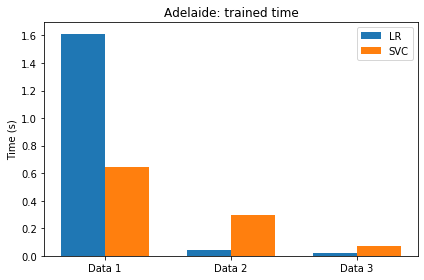

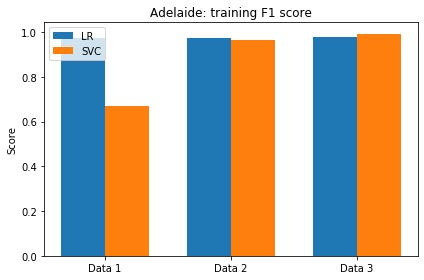

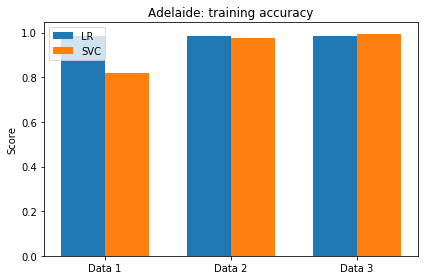

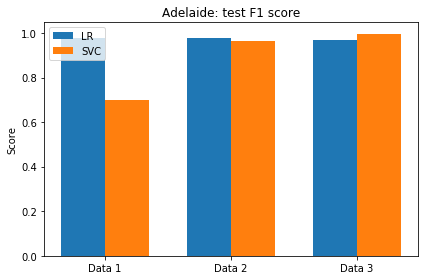

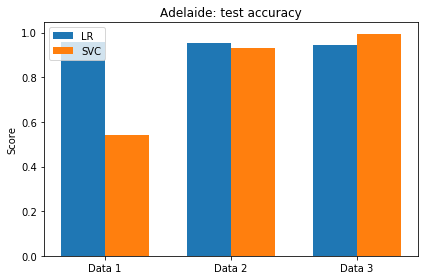

In [63]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X11_trained_time, A_X12_trained_time, A_X13_trained_time]
x3 = [C_X11_trained_time, C_X12_trained_time, C_X13_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Adelaide: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X11_train_f1, A_X12_train_f1, A_X13_train_f1]
x3 = [C_X11_train_f1, C_X12_train_f1, C_X13_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X11_train_acc, A_X12_train_acc, A_X13_train_acc]
x3 = [C_X11_train_acc, C_X12_train_acc, C_X13_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X11_test_f1, A_X12_test_f1, A_X13_test_f1]
x3 = [C_X11_test_f1, C_X12_test_f1, C_X13_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X11_test_acc, A_X12_test_acc, A_X13_test_acc]
x3 = [C_X11_test_acc, C_X12_test_acc, C_X13_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Adelaide: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


Plot city 2 results

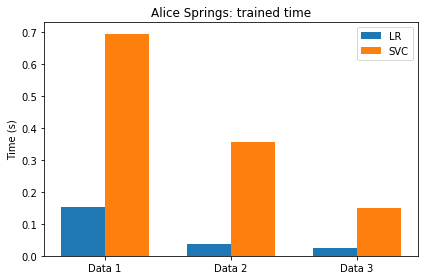

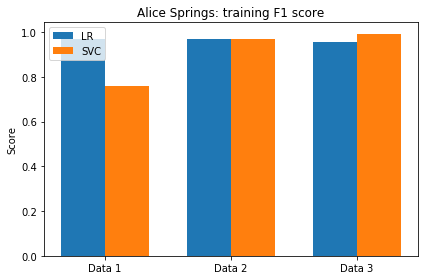

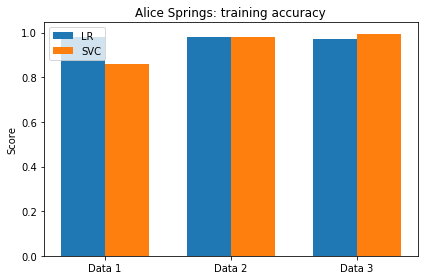

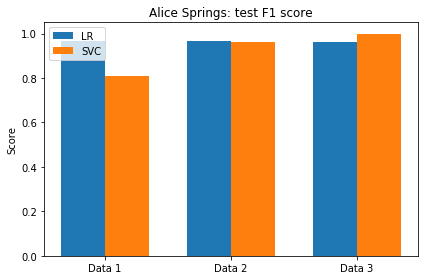

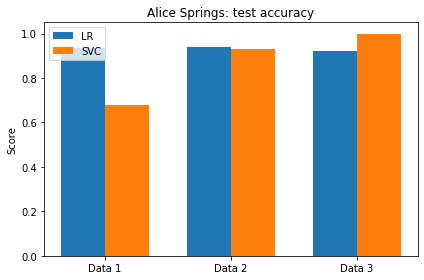

In [64]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X21_trained_time, A_X22_trained_time, A_X23_trained_time]
x3 = [C_X21_trained_time, C_X22_trained_time, C_X23_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Alice Springs: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X21_train_f1, A_X22_train_f1, A_X23_train_f1]
x3 = [C_X21_train_f1, C_X22_train_f1, C_X23_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Alice Springs: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X21_train_acc, A_X22_train_acc, A_X23_train_acc]
x3 = [C_X21_train_acc, C_X22_train_acc, C_X23_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Alice Springs: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X21_test_f1, A_X22_test_f1, A_X23_test_f1]
x3 = [C_X21_test_f1, C_X22_test_f1, C_X23_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Alice Springs: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X21_test_acc, A_X22_test_acc, A_X23_test_acc]
x3 = [C_X21_test_acc, C_X22_test_acc, C_X23_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Alice Springs: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Plot city 3 results

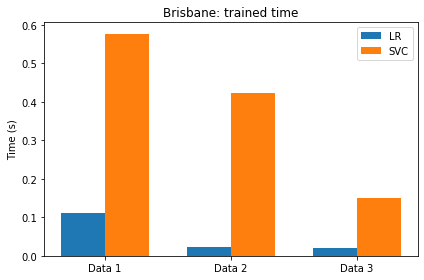

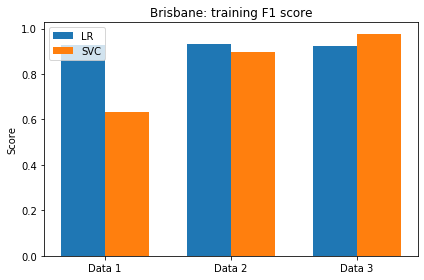

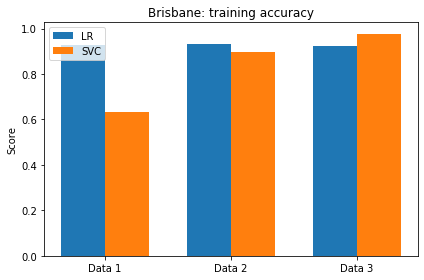

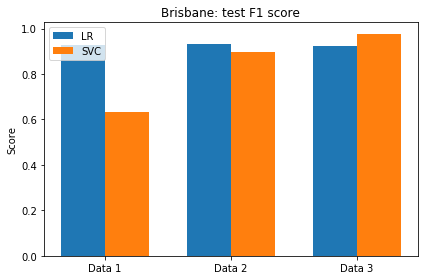

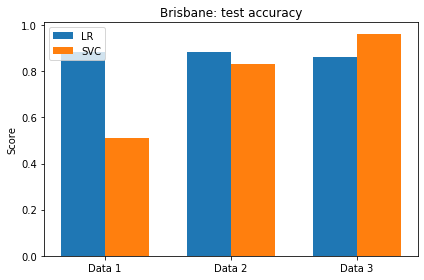

In [65]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X31_trained_time, A_X32_trained_time, A_X33_trained_time]
x3 = [C_X31_trained_time, C_X32_trained_time, C_X33_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Brisbane: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X31_train_f1, A_X32_train_f1, A_X33_train_f1]
x3 = [C_X31_train_f1, C_X32_train_f1, C_X33_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Brisbane: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X31_train_f1, A_X32_train_f1, A_X33_train_f1]
x3 = [C_X31_train_f1, C_X32_train_f1, C_X33_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Brisbane: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X31_train_f1, A_X32_train_f1, A_X33_train_f1]
x3 = [C_X31_train_f1, C_X32_train_f1, C_X33_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Brisbane: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X31_test_acc, A_X32_test_acc, A_X33_test_acc]
x3 = [C_X31_test_acc, C_X32_test_acc, C_X33_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Brisbane: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Plot city 4 results

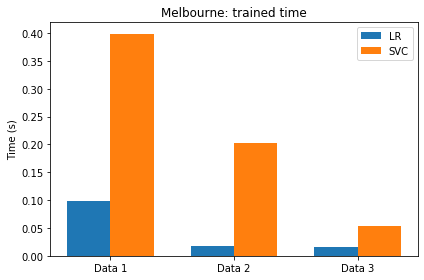

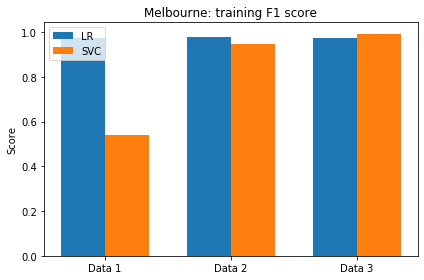

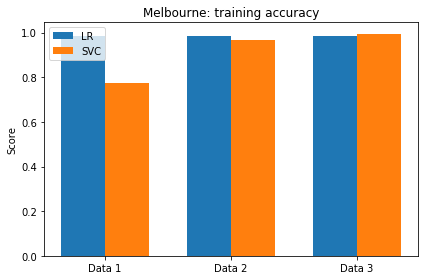

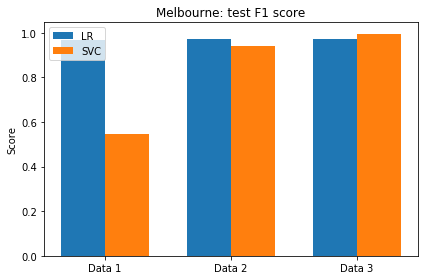

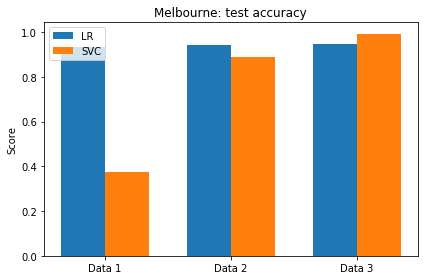

In [66]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X41_trained_time, A_X42_trained_time, A_X43_trained_time]
x3 = [C_X41_trained_time, C_X42_trained_time, C_X43_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Melbourne: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X41_train_f1, A_X42_train_f1, A_X43_train_f1]
x3 = [C_X41_train_f1, C_X42_train_f1, C_X43_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Melbourne: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X41_train_acc, A_X42_train_acc, A_X43_train_acc]
x3 = [C_X41_train_acc, C_X42_train_acc, C_X43_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Melbourne: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X41_test_f1, A_X42_test_f1, A_X43_test_f1]
x3 = [C_X41_test_f1, C_X42_test_f1, C_X43_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Melbourne: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X41_test_acc, A_X42_test_acc, A_X43_test_acc]
x3 = [C_X41_test_acc, C_X42_test_acc, C_X43_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Melbourne: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


Plot city 5 results

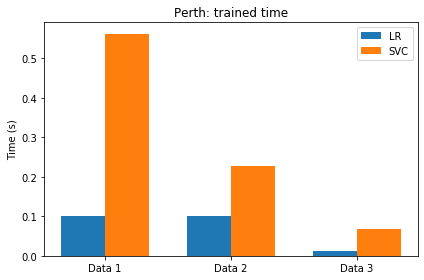

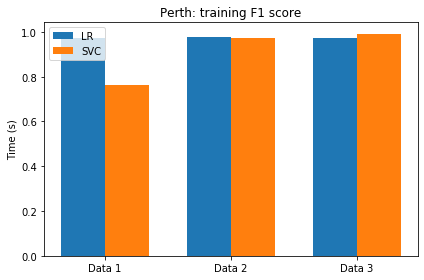

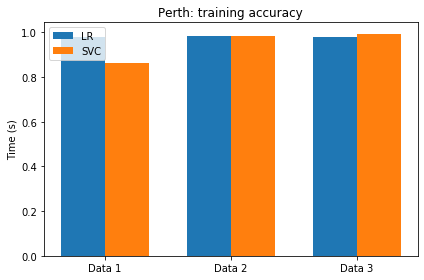

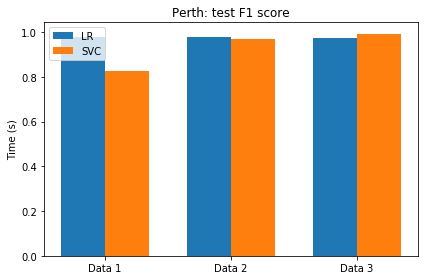

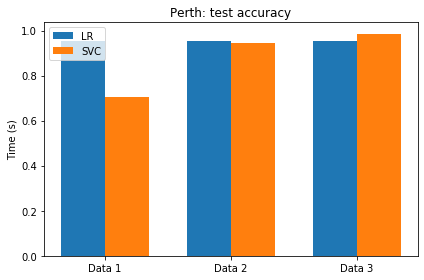

In [67]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X51_trained_time, A_X52_trained_time, A_X53_trained_time]
x3 = [C_X51_trained_time, C_X52_trained_time, C_X53_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Perth: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X51_train_f1, A_X52_train_f1, A_X53_train_f1]
x3 = [C_X51_train_f1, C_X52_train_f1, C_X53_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Perth: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X51_train_acc, A_X52_train_acc, A_X53_train_acc]
x3 = [C_X51_train_acc, C_X52_train_acc, C_X53_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Perth: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X51_test_f1, A_X52_test_f1, A_X53_test_f1]
x3 = [C_X51_test_f1, C_X52_test_f1, C_X53_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Perth: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X51_test_acc, A_X52_test_acc, A_X53_test_acc]
x3 = [C_X51_test_acc, C_X52_test_acc, C_X53_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Perth: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


Plot city 6 results

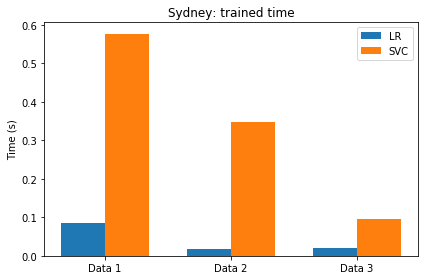

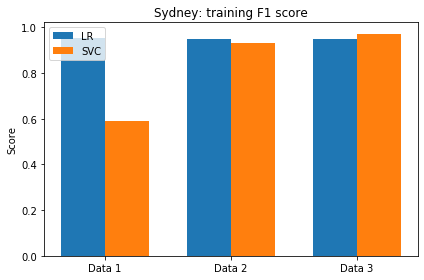

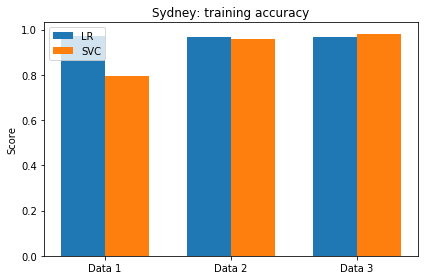

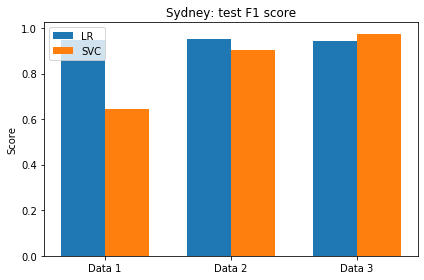

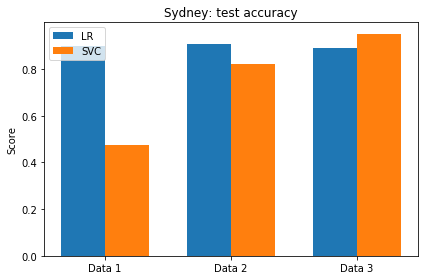

In [68]:
labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X61_trained_time, A_X62_trained_time, A_X63_trained_time]
x3 = [C_X61_trained_time, C_X62_trained_time, C_X63_trained_time]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Sydney: trained time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X61_train_f1, A_X62_train_f1, A_X63_train_f1]
x3 = [C_X61_train_f1, C_X62_train_f1, C_X63_train_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Sydney: training F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X61_train_acc, A_X62_train_acc, A_X63_train_acc]
x3 = [C_X61_train_acc, C_X62_train_acc, C_X63_train_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Sydney: training accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X61_test_f1, A_X62_test_f1, A_X63_test_f1]
x3 = [C_X61_test_f1, C_X62_test_f1, C_X63_test_f1]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Sydney: test F1 score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# -------------------------- 

labels = ['Data 1', 'Data 2', 'Data 3']
x1 = [A_X61_test_acc, A_X62_test_acc, A_X63_test_acc]
x3 = [C_X61_test_acc, C_X62_test_acc, C_X63_test_acc]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, x1, width, label='LR')
rects3 = ax.bar(x + width/2, x3, width, label='SVC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Sydney: test accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()